Вторая модель

In [75]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [76]:
test_df = pd.read_excel("data/test.xlsx")  # Файл с обучающими данными
sorted_df = pd.read_excel("sorted.xlsx")
combi_dt = pd.concat([sorted_df, test_df], ignore_index=True)
combi_dt['dt'] = pd.to_datetime(combi_dt['dt'])
sorted_dt = combi_dt.sort_values(by='dt')
sorted_dt = sorted_dt.drop_duplicates()
result_file = 'sorted.xlsx'
sorted_dt.to_excel(result_file, index=False)


In [77]:
combi_dt.shape
print("\nПропущенные значения:")
print(combi_dt.isnull().sum())
print("\nКоличество дубликатов:")
print(combi_dt.duplicated().sum())
print("\nОписательная статистика:")
combi_dt.describe()


Пропущенные значения:
dt                  0
Цена на арматуру    0
dtype: int64

Количество дубликатов:
28

Описательная статистика:


,dt,Цена на арматуру
count,456,456.000000
mean,2019-05-04 11:09:28.421052672,39846.030702
min,2015-01-05 00:00:00,21000.000000
25%,2017-03-11 06:00:00,32000.000000
50%,2019-05-16 12:00:00,37350.000000
75%,2021-07-20 18:00:00,44125.000000
max,2023-03-13 00:00:00,79000.000000
std,NaN,12725.831385


In [78]:
for df in [sorted_df, test_df]:
    df["dt"] = pd.to_datetime(df["dt"], errors='coerce')
    df["year"] = df["dt"].dt.year
    df["month"] = df["dt"].dt.month
    df["day"] = df["dt"].dt.day
    df["week"] = df["dt"].dt.isocalendar().week
    df.drop(columns=["dt"], errors="ignore", inplace=True)

In [79]:
X = sorted_df.drop(columns=['Цена на арматуру']).iloc[:-1, :]  # Замените "target" на название целевой переменной
y = sorted_df['Цена на арматуру'].values[1:]
X['Price_target'] = y
X['Price_source'] = sorted_df['Цена на арматуру'].values[:-1]
price_diff = X['Price_source'] - X['Price_target']
y = X['Price_target']
X = X.drop(columns=['Price_target'])
X = X.drop([0])
X['Price_Diff'] = price_diff.values[:-1]
X

,year,month,day,week,Price_source,Price_Diff
1,2015,1,12,3,32500,400
2,2015,1,19,4,32000,500
3,2015,1,26,5,30700,1300
4,2015,2,2,6,30300,400
5,2015,2,9,7,30300,0
...,...,...,...,...,...,...
422,2023,2,6,6,44500,-1700
423,2023,2,13,7,44500,0
424,2023,2,20,8,46000,-1500
425,2023,2,27,9,49200,-3200


In [80]:
print(sorted_df)
sorted_df = sorted_df.sort_values(by=['year', 'month', 'day', 'week'])

     Цена на арматуру  year  month  day  week
0               32900  2015      1    5     2
1               32500  2015      1   12     3
2               32000  2015      1   19     4
3               30700  2015      1   26     5
4               30300  2015      2    2     6
..                ...   ...    ...  ...   ...
423             44500  2023      2   13     7
424             46000  2023      2   20     8
425             49200  2023      2   27     9
426             53700  2023      3    6    10
427             55500  2023      3   13    11

[428 rows x 5 columns]


In [81]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Пересинхронизация индексов
y = y[X.index]
X = X.sort_index()
y = y.loc[X.index]

# Разделение данных на обучающую и тестовую выборки
X_train, X_holdout, y_train, y_holdout = train_test_split(
    X, y, test_size=0.2, shuffle=True, random_state=42
)

# Инициализация модели
model1 = RandomForestRegressor(n_estimators=1000, max_depth=7, random_state=42, verbose=1)

# Разделение данных на обучающую и валидационную выборки
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

# Обучение модели
model1.fit(X_train, y_train)

# Предсказания
y_pred = model1.predict(X_valid)
y_pred_holdout = model1.predict(X_holdout)

# Вычисление метрик
mae = mean_absolute_error(y_valid, y_pred)
rmse = np.sqrt(mean_squared_error(y_valid, y_pred))
r2 = r2_score(y_valid, y_pred)

# Вывод результатов
print(f"MAE: {mae:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"R2 Score: {r2:.4f}")

[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.2s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.7s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    1.3s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done  49 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 199 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 449 tasks      | elapsed:    0.0s
[Parallel(n_jobs=1)]: Done 799 tasks      | elapsed:    0.0s


MAE: 1135.9161
RMSE: 1843.5457
R2 Score: 0.9773


In [82]:
print("Размер y_holdout:", y_holdout.shape)
print("Размер y_pred_holdout:", y_pred_holdout.shape)
print("Первые 5 значений y_holdout:")
print(y_holdout.head())

print("Первые 5 значений y_pred_holdout:")
print(y_pred_holdout[:5])

Размер y_holdout: (86,)
Размер y_pred_holdout: (86,)
Первые 5 значений y_holdout:
419    42800
76     35400
177    37600
31     24400
358    72500
Name: Price_target, dtype: int64
Первые 5 значений y_pred_holdout:
[43163.44750756 36392.79875829 38979.369729   24570.41200453
 72368.84818182]


In [83]:
print(y_holdout.index[:10])  # Посмотрим первые 10 значений

Index([419, 76, 177, 31, 358, 348, 155, 154, 416, 158], dtype='int64')


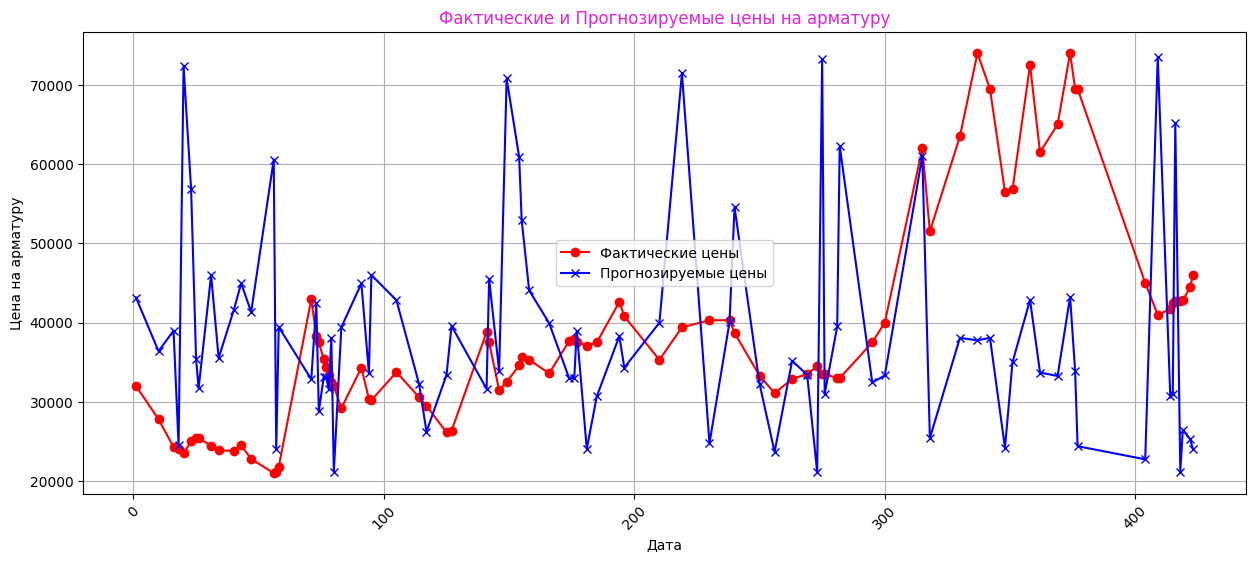

In [84]:
y_holdout = y_holdout.sort_index()
y_pred_holdout = pd.Series(y_pred_holdout, index=y_holdout.index).sort_index()


plt.figure(figsize=(15, 6))


# Фактические цены
plt.plot(y_holdout.index, y_holdout.values, label="Фактические цены", color='red', marker='o')

# Прогнозируемые цены
plt.plot(y_holdout.index, y_pred_holdout, label="Прогнозируемые цены", color='blue', marker='x')
plt.legend()
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Фактические и Прогнозируемые цены на арматуру", color='#de25da')
plt.xticks(rotation=45)
plt.grid(True)  # Добавляем сетку для лучшей читаемости
plt.show()

In [86]:
import joblib
joblib.dump(model1, "RandomForestRegressor.pkl")

['RandomForestRegressor.pkl']